# Optics calculation and matching for a large ring (LHC) - part 2 

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import numpy as np
import matplotlib.pyplot as plt

### Load LHC model

In [3]:
collider = xt.Multiline.from_json("hllhc15_collider_thick.json")
collider.build_trackers()
collider.vars.load_madx_optics_file("opt_round_150_1500.madx")

Loading line from dict:   0%|          | 0/29009 [00:00<?, ?it/s]

Done loading line from dict.           


### Prepare for optics matching: set limits and steps for all circuits

In [4]:
import lhc_match as lm
lm.set_var_limits_and_steps(collider)

## Large rematch in a single python function (B1 & B2)

In [5]:
optimizers = lm.change_beta15(collider, 
                 betx_ip1_target=0.15, bety_ip1_target=0.10,
                 betx_ip5_target=0.10, bety_ip5_target=0.15)

Step 1/3
Matching betx_ip1=0.15 bety_ip1=0.13333333333333333 betx_ip5=0.13333333333333333 bety_ip5=0.15
Matching IR2 b1
                                             
Optimize - start penalty: 11.23                             
Matching: model call n. 89 penalty = 4.2221e-08              
Optimize - end penalty:  4.22206e-08                            
Matching IR3 b1
                                             
Optimize - start penalty: 1.117e-07                         
Matching: model call n. 19 penalty = 4.0957e-08              
Optimize - end penalty:  4.09569e-08                            
Matching IR4 b1
                                             
Optimize - start penalty: 7.322                             
Matching: model call n. 102 penalty = 7.4301e-08              
Optimize - end penalty:  7.43007e-08                            
Matching IP6 b1
                                             
Optimize - start penalty: 2.455                             
Matching: model call n

In [6]:
# Count number of modified circuits
n_circuits = 0
for bb in ['b1', 'b2']:
    for irn in ['ir2', 'ir4', 'ir6', 'ir8']:
        n_circuits += len(optimizers[bb][irn].vary)
print('N. modified circuits:', n_circuits)

N. modified circuits: 146


#### Inspect result

In [7]:
twb1 = collider.lhcb1.twiss()
twb2 = collider.lhcb2.twiss()

print('B1:')
twb1.rows['ip.*'].cols['betx bety mux muy x y'].show(digits=4)
print()
print('B2:')
twb2.rows['ip.*'].cols['betx bety mux muy x y'].show(digits=4)

B1:
name          betx        bety         mux         muy           x           y
ip1           0.15         0.1           0           0           0           0
ip2             10          10       8.242       7.693  -2.088e-17   9.347e-36
ip3          121.6       218.6       15.95       15.45     3.8e-16  -2.103e-35
ip4          236.2       306.2        23.5       22.43   2.828e-17   -3.25e-35
ip5            0.1        0.15       30.93       29.99  -1.952e-18   1.384e-37
ip6          320.1       181.8       38.75        37.4   6.832e-16  -3.754e-35
ip7          120.8       149.4       46.35       44.59  -2.243e-16    2.99e-35
ip8            1.5         1.5       54.34       52.26  -4.534e-17   -1.88e-33
ip1.l1        0.15         0.1       62.31       60.32  -1.764e-17  -1.142e-33

B2:
name          betx        bety         mux         muy           x           y
ip1           0.15         0.1           0           0  -6.355e-18    3.29e-34
ip2             10          10       7.685 

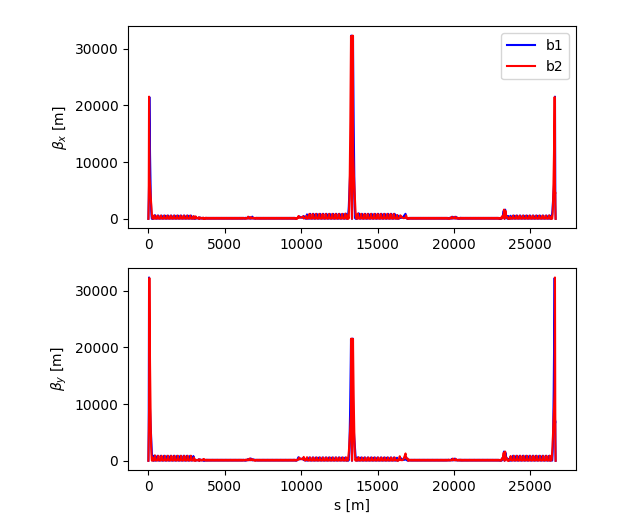

In [8]:
plt.figure(figsize=(6.4, 4.8*1.1))
ax1 = plt.subplot(2,1,1)
ax1.plot(twb1.s, twb1.betx, color='blue', label='b1')
ax1.plot(twb2.s, twb2.betx, color='red', label='b2')
plt.ylabel(r'$\beta_x$ [m]')
plt.legend()

ax2 = plt.subplot(2,1,2)
ax2.plot(twb1.s, twb1.bety, color='blue', label='b1')
ax2.plot(twb2.s, twb2.bety, color='red', label='b1')
plt.ylabel(r'$\beta_y$ [m]')
plt.xlabel('s [m]')

plt.subplots_adjust(left=0.2, top=.95)

### Rematch IR orbit knobs

As we have changed the IR quads we need to rematch all the IR orbit knobs (crossing angles, separations, offsets, etc.)

In [9]:
optimizers_ip_knobs = lm.match_orbit_knobs_ip2_ip8(collider)

                                             
Optimize - start penalty: 0.007071                          
Matching: model call n. 21 penalty = 1.1294e-10              
Optimize - end penalty:  1.12938e-10                            
Generated knob:  on_o2v
                                             
Optimize - start penalty: 0.007071                          
Matching: model call n. 11 penalty = 1.3705e-09              
Optimize - end penalty:  1.37054e-09                            
Generated knob:  on_o2h
                                             
Optimize - start penalty: 0.007071                          
Matching: model call n. 21 penalty = 8.1268e-10              
Optimize - end penalty:  8.12681e-10                            
Generated knob:  on_o8v
                                             
Optimize - start penalty: 0.007071                          
Matching: model call n. 31 penalty = 1.5711e-09              
Optimize - end penalty:  1.57112e-09                     

In [10]:
print('Generated knobs:', list(optimizers_ip_knobs.keys()))

Generated knobs: ['on_o2h', 'on_o2v', 'on_o8h', 'on_o8v', 'on_a2h', 'on_a2v', 'on_a8h', 'on_a8v', 'on_x2h', 'on_x2v', 'on_x8h', 'on_x8v', 'on_sep2h', 'on_sep2v', 'on_sep8h', 'on_sep8v']


#### Inspect one crossing knob

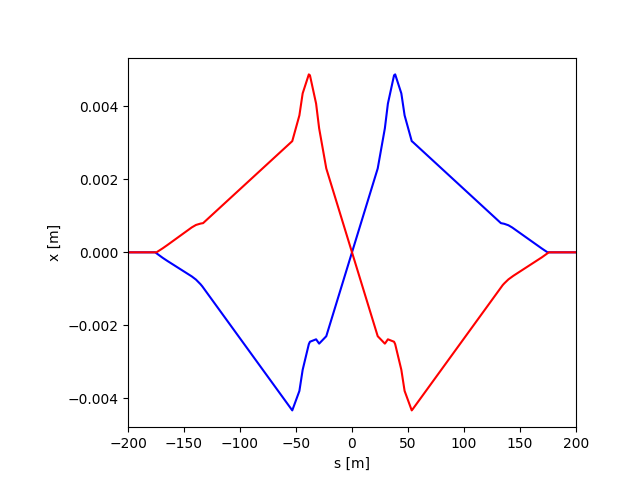

In [11]:
collider.vars['on_x8h'] = 100 

tw = collider.twiss()
plt.figure()
plt.plot(tw.lhcb1.s - tw.lhcb1['s', 'ip8'], tw.lhcb1.x, 'b')
plt.plot(tw.lhcb2.s - tw.lhcb2['s', 'ip8'], tw.lhcb2.x, 'r')
plt.xlim(-200, 200)
plt.xlabel('s [m]')
plt.ylabel('x [m]')
plt.subplots_adjust(left=.2)

# MAD-NG interface

### Get MAD-NG model from Xsuite
We can easily generate the corresponding MAD-NG model ([pymadng](https://pymadng.readthedocs.io/en/latest/) used under the hood)

In [12]:
ttv = collider.vars.get_table()

In [13]:
ttv.rows['rref_mpcorr.*']

VarsTable: 5 rows, 3 cols
name                  value expr
rref_mpcorr            0.05 None
rref_mpcorr^2             0 None
rref_mpcorr^3             0 None
rref_mpcorr^4             0 None
rref_mpcorr^5             0 None

In [14]:
mng = collider.lhcb1.to_madng(sequence_name='lhcb1')

RuntimeError: MAD Errored (see the MAD error output)

### Use MAD-NG TPSA to compute octupolar RDTs

In [ ]:
mng.send('''
    local damap in MAD
    local lhc = MADX.lhcb1
    
    -- list of octupolar RDTs
    local rdts = {"f4000", "f3100", "f2020", "f1120"}
    
    -- create phase-space damap at 4th order
    local X0 = damap {nv=6, mo=4}
    
    -- twiss with RDTs
    local mtbl = twiss {sequence=lhc, X0=X0, trkrdt=rdts, info=2, saverdt=true}
    
    -- send columns to Python
    py:send({mtbl.s, mtbl.beta22, mtbl.f4000, mtbl.f3100, mtbl.f2020, mtbl.f1120})

''')

s, beta22, f4000, f3100, f2020, f1120 = mng.recv()

In [ ]:
plt.figure(figsize=(6.4, 4.8*1.1))
ax1 = plt.subplot(2,1,1)
ax1.plot(s, beta22)
plt.ylabel(r'$\beta_y$ [m]')

ax2 = plt.subplot(2,1,2)
plt.plot(s, np.abs(f4000), label='f4000')
plt.plot(s, np.abs(f2020), label='f2020')
plt.plot(s, np.abs(f1120), label='f1120')
plt.plot(s, np.abs(f3100), label='f3100')
plt.xlabel('s [m]')
plt.ylabel(r'|$f_{jklm}$|')
plt.legend()